In [24]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
from statsmodels.api import OLS
from statsmodels.tools import add_constant

In [25]:
ff5_month = pdr.get_data_famafrench('F-F_Research_Data_5_Factors_2x3', start='1963-07', end='2023-03')[0]
ff5_month = ff5_month / 100
mom_month = pdr.get_data_famafrench('F-F_Momentum_Factor', start='1927-01', end='2023-03')[0]
mom_month = mom_month / 100

ff5_month = ff5_month.reset_index()
mom_month = mom_month.reset_index()
ff5mom_month = ff5_month.merge(mom_month, on='Date', how='right')
ff5mom_month = ff5mom_month.set_index('Date')

In [26]:
ff5_daily = pdr.get_data_famafrench('F-F_Research_Data_5_Factors_2x3_daily', start='1963-07-01', end='2023-03-31')[0]
ff5_daily = ff5_daily / 100
mom_daily = pdr.get_data_famafrench('F-F_Momentum_Factor_daily', start='1926-11-03', end='2023-03-31')[0]
mom_daily = mom_daily / 100

ff5_daily = ff5_daily.reset_index()
mom_daily = mom_daily.reset_index()
ff5mom_daily = ff5_daily.merge(mom_daily, on='Date', how='right')
ff5mom_daily = ff5mom_daily.set_index('Date')

In [27]:
ff5mom_month.dropna(inplace=True)

In [28]:
# calculate rolling variance
rolling_window = 12 # You can adjust this value
ff5mom_month_rolling_var = ff5mom_month.rolling(window=rolling_window).var()

# reshape the monthly factor dataframe
ff5mom_month_rolling_var = ff5mom_month_rolling_var.reset_index().melt(id_vars='Date', var_name='Factor', value_name='RollingVar')
ff5mom_month_reshaped = ff5mom_month.reset_index().melt(id_vars='Date', var_name='Factor', value_name='FactorReturns')

# merge the reshaped monthly factor dataframe with the rolling variance dataframe
df = pd.merge(ff5mom_month_reshaped, ff5mom_month_rolling_var, on=['Date', 'Factor'])

# calculate inverse of rolling variance
df['InvRollingVar'] = 1 / df['RollingVar']

# group by date to calculate weights
df['Weight'] = df.groupby('Date')['InvRollingVar'].apply(lambda x: x / x.sum())

# calculate lag weights using shift
df['LagWeight'] = df.groupby('Factor')['Weight'].shift()

# calculate monthly volatility-managed portfolio excess returns
df['ExcessReturns'] = df['LagWeight'] * df['FactorReturns']
monthly_excess_returns = df.groupby('Date')['ExcessReturns'].sum()


In [29]:
def estimate_models(excess_returns, ff5):
    # CAPM Model
    X = add_constant(ff5[['Mkt-RF']].loc[excess_returns.index])
    capm_model = OLS(excess_returns, X).fit()

    # FF3 Model
    X = add_constant(ff5[['Mkt-RF', 'SMB', 'HML']].loc[excess_returns.index])
    ff3_model = OLS(excess_returns, X).fit()

    # Carhart Model
    X = add_constant(ff5[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].loc[excess_returns.index])
    carhart_model = OLS(excess_returns, X).fit()

    print(ff5.columns)
    # FF5 Model
    X = add_constant(ff5[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'Mom   ']].loc[excess_returns.index,:])
    ff5_model = OLS(excess_returns, X).fit()

    return capm_model, ff3_model, carhart_model, ff5_model

ff5_pruned = ff5mom_month.dropna()
ff5_pruned.sort_index(inplace=True)
excess_returns = monthly_excess_returns.loc[ff5_pruned.index]
excess_returns.sort_index(inplace=True)

capm_model, ff3_model, carhart_model, ff5_model = estimate_models(excess_returns, ff5_pruned)

Index(['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'Mom   '], dtype='object')


In [30]:
print(capm_model.summary())
print(ff3_model.summary())
print(carhart_model.summary())
print(ff5_model.summary())

                            OLS Regression Results                            
Dep. Variable:          ExcessReturns   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     5.745
Date:                Tue, 16 May 2023   Prob (F-statistic):             0.0168
Time:                        18:43:06   Log-Likelihood:                 3234.6
No. Observations:                 717   AIC:                            -6465.
Df Residuals:                     715   BIC:                            -6456.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.000     35.768      0.0

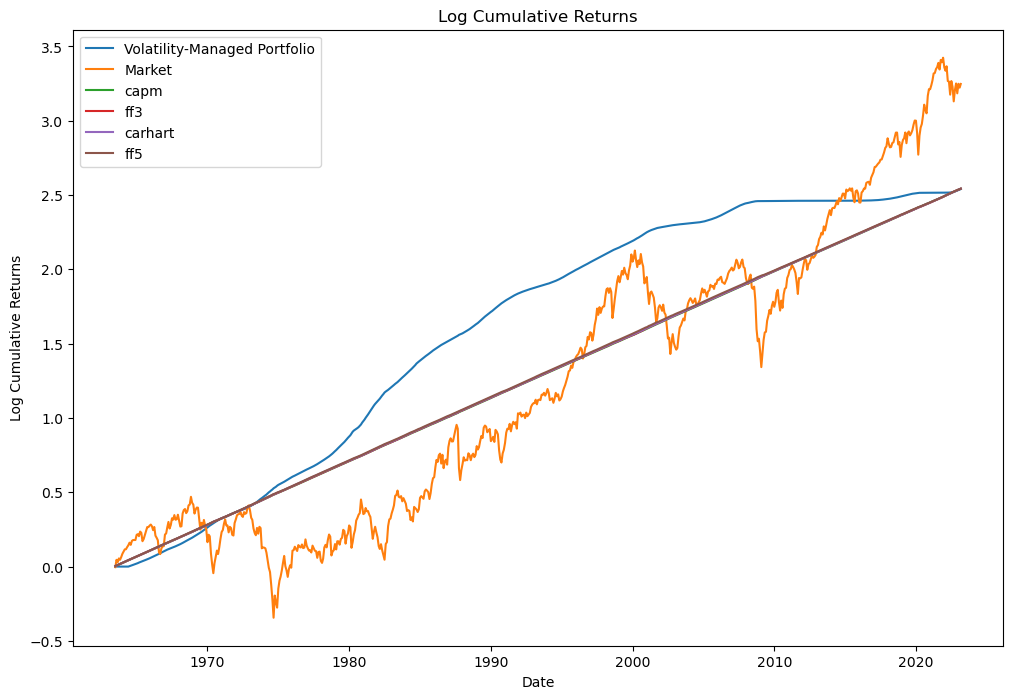

In [31]:
import matplotlib.pyplot as plt

# calculate log cumulative returns
portfolio_cum_returns = np.log(1 + excess_returns).cumsum()
market_cum_returns = np.log(1 + ff5_pruned['Mkt-RF']).cumsum()
capm_cum_returns = np.log(1 + capm_model.predict()).cumsum()
ff3_cum_returns = np.log(1 + ff3_model.predict()).cumsum()
carhart_cum_returns = np.log(1 + carhart_model.predict()).cumsum()
ff5_cum_returns = np.log(1 + ff5_model.predict()).cumsum()

dt_index = excess_returns.index.to_timestamp()

# plot
plt.figure(figsize=(12, 8))
plt.plot(dt_index, list(portfolio_cum_returns), label='Volatility-Managed Portfolio')
plt.plot(dt_index, list(market_cum_returns), label='Market')
plt.plot(dt_index, list(capm_cum_returns), label='capm')
plt.plot(dt_index, list(ff3_cum_returns), label='ff3')
plt.plot(dt_index, list(carhart_cum_returns), label='carhart')
plt.plot(dt_index, list(ff5_cum_returns), label='ff5')
plt.xlabel('Date')

plt.ylabel('Log Cumulative Returns')
plt.title('Log Cumulative Returns')
plt.legend()
plt.show()

(b) It seems that the aggregat portfolio outperforms each composite portfolio

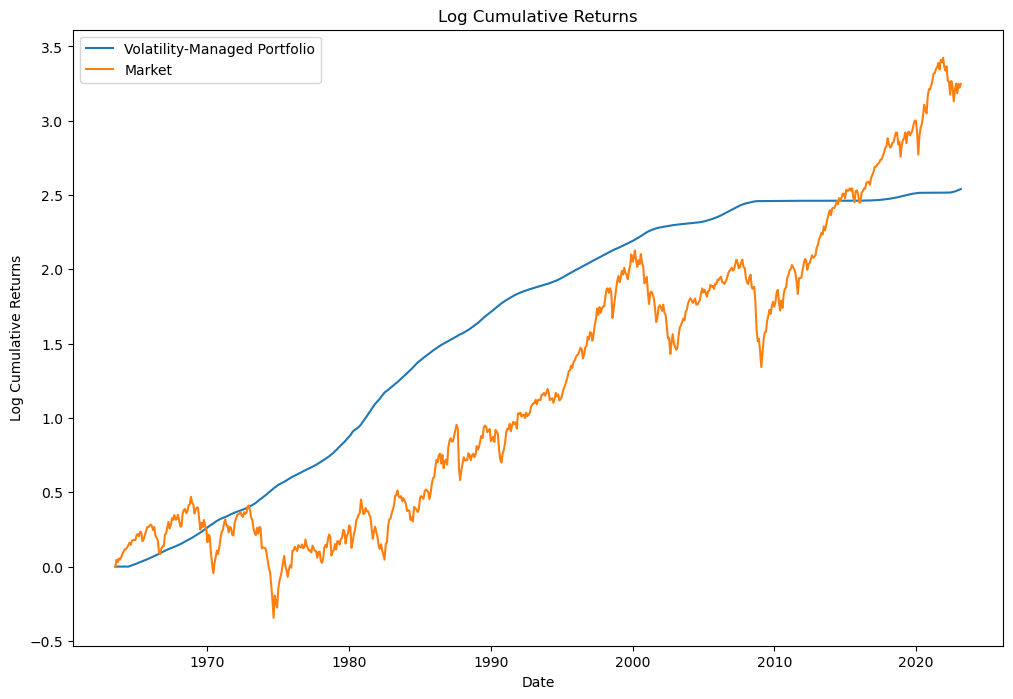

In [32]:
import matplotlib.pyplot as plt

# calculate log cumulative returns
portfolio_cum_returns = np.log(1 + excess_returns).cumsum()
market_cum_returns = np.log(1 + ff5_pruned['Mkt-RF']).cumsum()

dt_index = excess_returns.index.to_timestamp()

# plot
plt.figure(figsize=(12, 8))
plt.plot(dt_index, list(portfolio_cum_returns), label='Volatility-Managed Portfolio')
plt.plot(dt_index, list(market_cum_returns), label='Market')
plt.xlabel('Date')
plt.ylabel('Log Cumulative Returns')
plt.title('Log Cumulative Returns')
plt.legend()
plt.show()

(c) The volatility-managed portfolio produces alpha because it seeks to reduce risk by adjusting portfolio weights based on the volatility of the underlying assets. By doing this, the portfolio maintains a more stable performance during periods of high market volatility, which in turn leads to better risk-adjusted returns compared to the market. 

However, the cumulative returns suggest that the volatility-managed portfolio does not beat the market since the turn of the century. This can be due to a few reasons:
- Changing market conditions since the turn of the century, especially apparent with the effective flatline around 2008
- During periods of strong market performance, higher-risk assets tend to deliver better returns, resulting in this risk-averse strategy underperforming
- During periods of low volatilty this portfolio is less effective